In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    mean_absolute_percentage_error,
    matthews_corrcoef,
    cohen_kappa_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the Dataset
data = pd.read_csv(r"D:\CS6501\PROJECT WORKS\Final Dataset-v.1\Dataset-1.csv")
print("Dataset Loaded:")
print(data.head())

Dataset Loaded:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26     

In [3]:
# Dataset Overview
print("\nDataset Summary:")
print(data.describe())  # Statistical summary of the dataset
print("\nDataset Info:")
print(data.info())  # Dataset information


Dataset Summary:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.804747e-12 -6.644481e-13 -5.733476e-13  7.602684e-13   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   2.290382e-13  6.119060e-14  3.241792e-14 -5.131360e-13 -7.735175e-13   
std    1.380247e+00  1.3

In [4]:
# Remove Duplicate Rows
data = data.drop_duplicates()
print(f"\nDataset shape after removing duplicates: {data.shape}")


Dataset shape after removing duplicates: (283726, 31)


In [5]:
# Handle Missing Values
data.fillna(data.mean(), inplace=True)
print("Missing values handled.")

Missing values handled.


In [6]:
# Remove outliers
def remove_outliers(data):
    for col in data.select_dtypes(include=['number']).columns:
        if col != 'Class':  # Do not remove rows affecting the target variable
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data = data[(data[col] >= lower_bound) | (data['Class'] == 1)]
    return data

# Apply the outlier removal function
data_cleaned = remove_outliers(data)
print(f"Cleaned Dataset IsFraud Distribution:")
print(data_cleaned['Class'].value_counts())

Cleaned Dataset IsFraud Distribution:
Class
0    188657
1       473
Name: count, dtype: int64


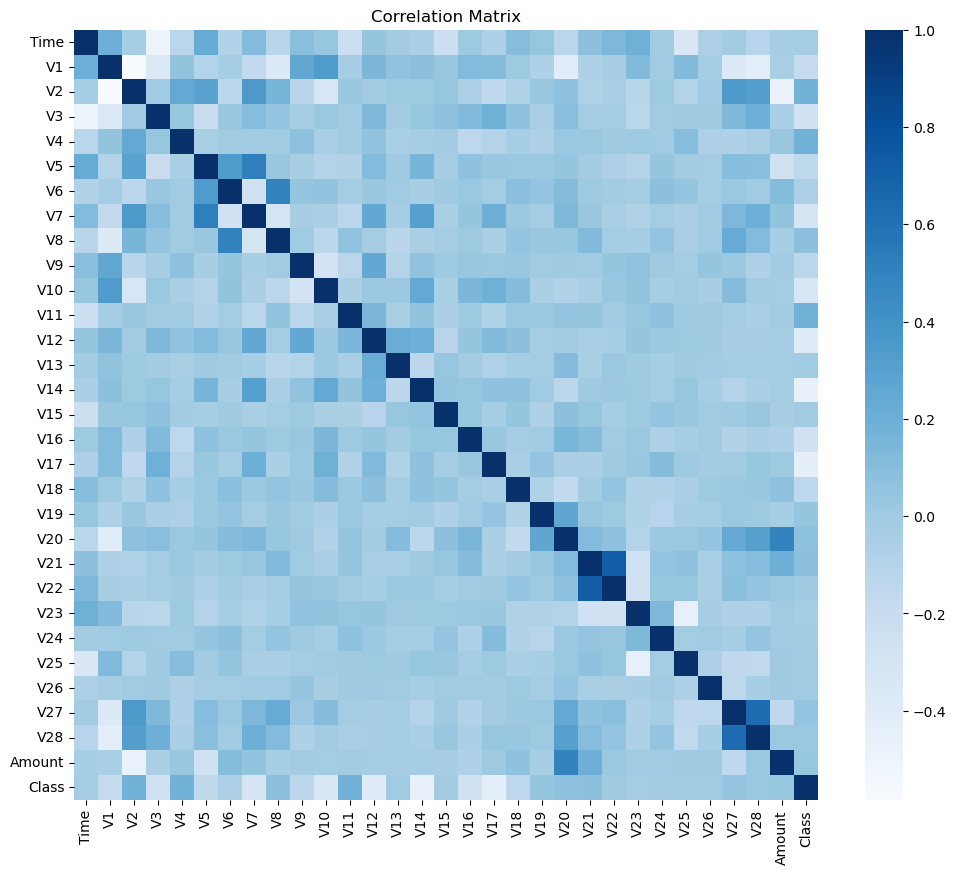

In [7]:
# Display Correlation Matrix
corr_matrix = data_cleaned.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='Blues', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [8]:
# Remove Highly Correlated Features
correlation_threshold = 0.9
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            correlated_features.add(corr_matrix.columns[i])

data_cleaned = data_cleaned.drop(columns=correlated_features)
print(f"\nRemoved highly correlated features: {correlated_features}")
print(f"Dataset shape after removing correlated features: {data_cleaned.shape}")


Removed highly correlated features: set()
Dataset shape after removing correlated features: (189130, 31)


In [9]:
# Separate Features and Target
X = data_cleaned.drop('Class', axis=1)
y = data_cleaned['Class']

In [10]:
# Handle Class Imbalance using SMOTE
print("\nOriginal Class Distribution:")
print(y.value_counts())

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print("\nBalanced Class Distribution:")
print(pd.Series(y_balanced).value_counts())


Original Class Distribution:
Class
0    188657
1       473
Name: count, dtype: int64

Balanced Class Distribution:
Class
0    188657
1    188657
Name: count, dtype: int64


In [11]:
# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [12]:
# Function for stepwise forward selection
def stepwise_forward_selection(X, y, model, max_features=10):
    selected_features = []
    remaining_features = list(X.columns)
    best_score = 0

    print("\nStepwise Forward Selection Process:")
    print(f"Initial Features: {remaining_features}")
    while remaining_features and len(selected_features) < max_features:
        scores = []
        for feature in remaining_features:
            temp_features = selected_features + [feature]
            model.fit(X[temp_features], y)
            y_pred = model.predict(X[temp_features])
            scores.append((feature, f1_score(y, y_pred, zero_division=1)))

        best_feature, best_score_candidate = max(scores, key=lambda x: x[1])
        if best_score_candidate > best_score:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_score = best_score_candidate
            print(f"Selected Feature: {best_feature}, Score: {best_score_candidate}")
            print(f"Remaining Features: {remaining_features}")
        else:
            break

    print("\nFinal Selected Features:")
    print(selected_features)
    return selected_features

In [13]:
# Sample a subset for training
X_balanced_sampled, y_balanced_sampled = X_balanced.sample(n=20000, random_state=42), y_balanced.sample(n=20000, random_state=42)

In [14]:
# Dimensionality Reduction with PCA (reduce to 15 components)
pca = PCA(n_components=15, random_state=42)
X_sampled_pca = pca.fit_transform(X_balanced_sampled)

In [15]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled_pca, y_balanced_sampled, test_size=0.2, random_state=42, stratify=y_balanced_sampled
)

In [16]:
# Apply MinMax scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Define and train the Linear SVM
print("\nTraining SVM with Linear Kernel...")
svm_linear = SVC(kernel='linear', probability=True, random_state=42, max_iter=10000, tol=1e-3, C=1.0)
svm_linear.fit(X_train_scaled, y_train)
y_pred_linear = svm_linear.predict(X_test_scaled)
y_prob_linear = svm_linear.predict_proba(X_test_scaled)[:, 1]


Training SVM with Linear Kernel...


In [18]:
# Define and train the RBF SVM
print("\nTraining SVM with RBF Kernel...")
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42, max_iter=10000, tol=1e-3, C=1.0, gamma='scale')
svm_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svm_rbf.predict(X_test_scaled)
y_prob_rbf = svm_rbf.predict_proba(X_test_scaled)[:, 1]


Training SVM with RBF Kernel...



Accuracy: 0.9720
Precision: 0.9990
Recall: 0.9454
F1-Score: 0.9714
Matthews Correlation Coefficient: 0.9454
Cohen's Kappa Score: 0.9440


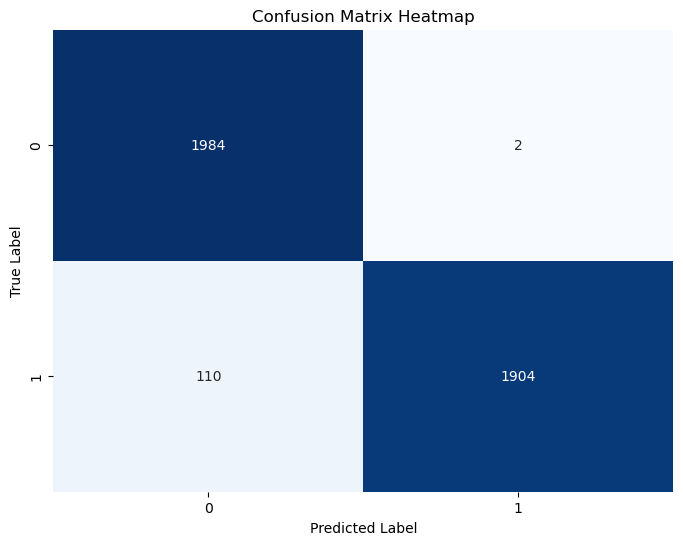

Root Mean Squared Error (RMSE): 0.1673
Residual Sum of Squares (RSS): 112.0000
Mean Absolute Percentage Error (MAPE): 2251799813685.2754
ROC-AUC Score: 0.9722


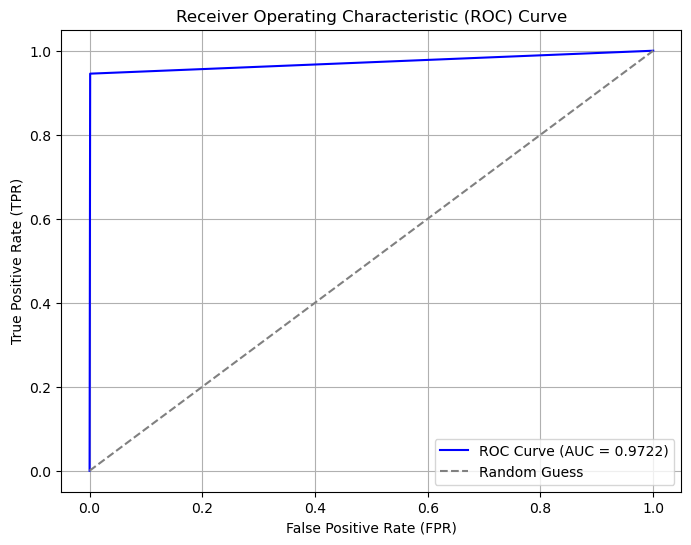

In [21]:
# Evaluate the Model for Linear

# Accuracy
accuracy = accuracy_score(y_test, y_pred_linear)
print(f"\nAccuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred_linear, zero_division=0)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred_linear, zero_division=0)
print(f"Recall: {recall:.4f}")

# F1-Score
f1 = f1_score(y_test, y_pred_linear, zero_division=0)
print(f"F1-Score: {f1:.4f}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred_linear)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Cohen's Kappa Score
cohens_kappa = cohen_kappa_score(y_test, y_pred_linear)
print(f"Cohen's Kappa Score: {cohens_kappa:.4f}")

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred_linear)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_linear))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Residual Sum of Squares (RSS)
rss = np.sum((y_test - y_pred_linear) ** 2)
print(f"Residual Sum of Squares (RSS): {rss:.4f}")

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred_linear)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_linear)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Generate and Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_linear)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


Accuracy: 0.9828
Precision: 0.9980
Recall: 0.9677
F1-Score: 0.9826
Matthews Correlation Coefficient: 0.9660
Cohen's Kappa Score: 0.9655


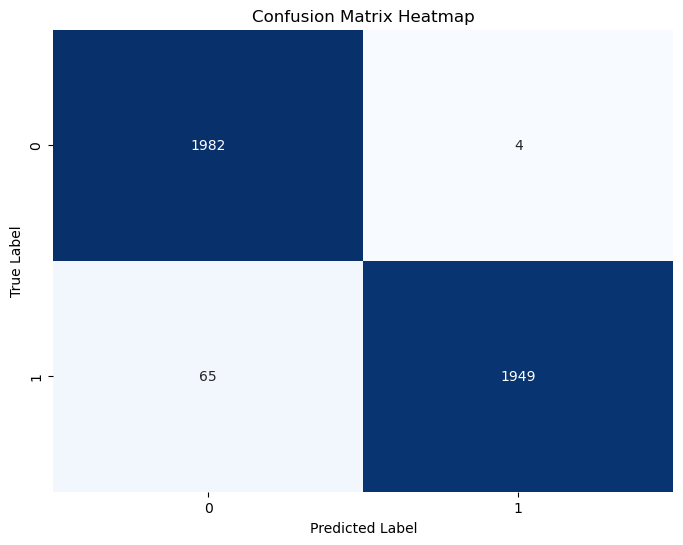

Root Mean Squared Error (RMSE): 0.1313
Residual Sum of Squares (RSS): 69.0000
Mean Absolute Percentage Error (MAPE): 4503599627370.5117
ROC-AUC Score: 0.9829


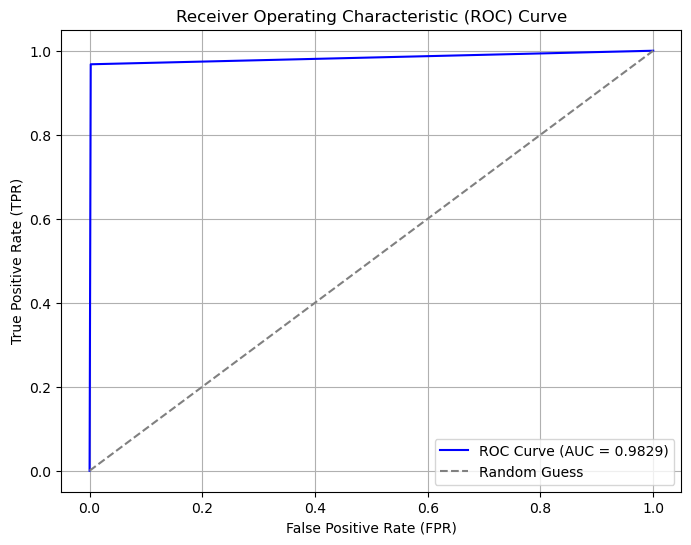

In [23]:
# Evaluate the Model for RBF

# Accuracy
accuracy = accuracy_score(y_test, y_pred_rbf)
print(f"\nAccuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred_rbf, zero_division=0)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred_rbf, zero_division=0)
print(f"Recall: {recall:.4f}")

# F1-Score
f1 = f1_score(y_test, y_pred_rbf, zero_division=0)
print(f"F1-Score: {f1:.4f}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred_rbf)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Cohen's Kappa Score
cohens_kappa = cohen_kappa_score(y_test, y_pred_rbf)
print(f"Cohen's Kappa Score: {cohens_kappa:.4f}")

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred_rbf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rbf))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Residual Sum of Squares (RSS)
rss = np.sum((y_test - y_pred_rbf) ** 2)
print(f"Residual Sum of Squares (RSS): {rss:.4f}")

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred_rbf)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_rbf)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Generate and Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rbf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [26]:
# Check for overfitting or underfitting with SVM (Linear Kernel)
train_accuracy = accuracy_score(y_train, svm_linear.predict(X_train_scaled))
test_accuracy = accuracy_score(y_test, y_pred_linear)

# Print accuracy scores
print(f"Training Accuracy (Linear Kernel): {train_accuracy:.4f}")
print(f"Testing Accuracy (Linear Kernel): {test_accuracy:.4f}")

# Determine model behavior
if train_accuracy > test_accuracy + 0.1:  
    print("The model might be overfitting (high training accuracy, low testing accuracy).")
elif test_accuracy > train_accuracy + 0.1:
    print("The model might be underfitting (low accuracy on both training and testing sets).")
else:
    print("The model appears to be well-fitted.")

Training Accuracy (Linear Kernel): 0.9762
Testing Accuracy (Linear Kernel): 0.9720
The model appears to be well-fitted.


In [27]:
# Check for overfitting or underfitting with SVM (RBF Kernel)
train_accuracy = accuracy_score(y_train, svm_rbf.predict(X_train_scaled))
test_accuracy = accuracy_score(y_test, y_pred_rbf)

# Print accuracy scores
print(f"Training Accuracy (RBF Kernel): {train_accuracy:.4f}")
print(f"Testing Accuracy (RBF Kernel): {test_accuracy:.4f}")

# Determine model behavior
if train_accuracy > test_accuracy + 0.1:  
    print("The model might be overfitting (high training accuracy, low testing accuracy).")
elif test_accuracy > train_accuracy + 0.1:
    print("The model might be underfitting (low accuracy on both training and testing sets).")
else:
    print("The model appears to be well-fitted.")

Training Accuracy (RBF Kernel): 0.9852
Testing Accuracy (RBF Kernel): 0.9828
The model appears to be well-fitted.
